# Total Variation Regularized Reconstruction

This notebook reproduce experiments with total variation regularized reconstruction described in [Accelerating Non-Cartesian MRI Reconstruction Convergence using k-space Preconditioning](https://arxiv.org/abs/1902.09657).

In [1]:
%matplotlib notebook

import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
import numpy as np

## Set parameters and load dataset

In [7]:
max_iter = 1000
lamda = 0.001
ksp_file = 'data/ute/ksp.npy'
coord_file = 'data/ute/coord.npy'

# Choose computing device.
# Device(-1) specifies CPU, while others specify GPUs.
# GPU requires installing cupy.
device = sp.Device(-1)
xp = device.xp
device.use()

# Load datasets.
ksp = xp.load(ksp_file)
coord = xp.load(coord_file)

## Estimate sensitivity maps using JSENSE

Here we use [JSENSE](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.21245) to estimate sensitivity maps.

In [3]:
mps = mr.app.JsenseRecon(ksp, coord=coord, device=device).run()

## Primal dual hybrid gradient reconstruction

<IPython.core.display.Javascript object>


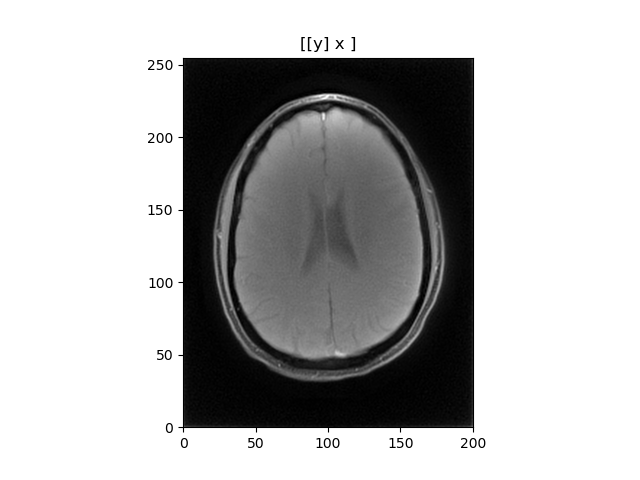

In [4]:
pdhg_app = mr.app.TotalVariationRecon(
        ksp, mps, lamda=lamda, coord=coord, max_iter=max_iter,
        alg_name='PrimalDualHybridGradient', device=device, save_objective_values=True)
pdhg_img = pdhg_app.run()

pl.ImagePlot(pdhg_img)

## Proposed reconstruction

<IPython.core.display.Javascript object>


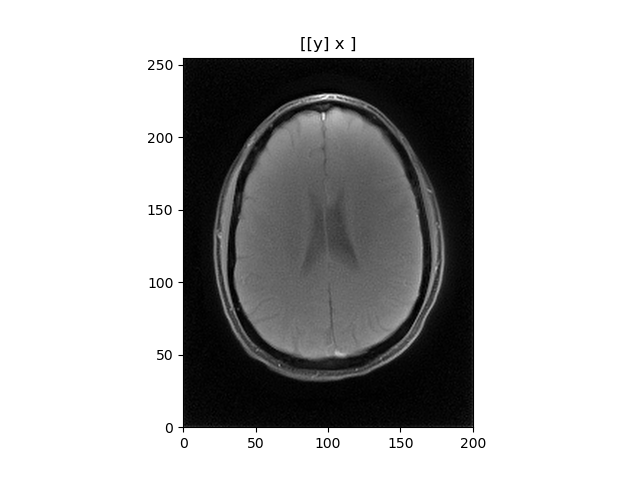

In [5]:
# Compute preconditioner
precond = mr.kspace_precond(mps, coord=coord, device=device)
img_shape = mps.shape[1:]
sigma2 = xp.ones([sp.prod(img_shape) * len(img_shape)],
                 dtype=ksp.dtype) / 2
sigma = xp.concatenate([precond.ravel(), sigma2.ravel()])

precond_app = mr.app.TotalVariationRecon(
        ksp, mps, lamda=lamda, coord=coord, sigma=sigma, max_iter=max_iter,
        alg_name='PrimalDualHybridGradient', device=device, save_objective_values=True)
precond_img = precond_app.run()

pl.ImagePlot(precond_img)

## Convergence curves

<IPython.core.display.Javascript object>


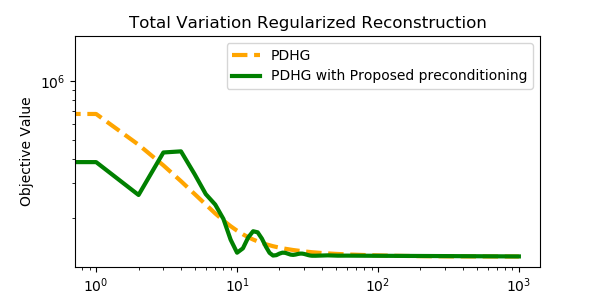

In [6]:
plt.figure(figsize=(6, 3))
plt.loglog(pdhg_app.objective_values,
               linestyle='--', linewidth=3, color='orange')
plt.loglog(precond_app.objective_values,
               linestyle='-', linewidth=3, color='green')
plt.legend(['PDHG',
            'PDHG with Proposed preconditioning'])
plt.ylabel('Objective Value')
plt.xlabel('Iteration')
plt.title(r"Total Variation Regularized Reconstruction")
plt.show()